In [8]:
from itertools import cycle
from collections import Counter
from copy import deepcopy


import numpy as np
import matplotlib.pyplot as plt


from src.agents.deep_q_agent import DeepQAgent
from src.agents.play_agents import RandomPlayer, DeepPlayer
from src.models.tictactoe_models import TicTacToeModel
from src.envs.play_env import TicTacToeGame
from src.envs.tictactoe_env import TicTacToeEnv

In [9]:
def get_performance_score(model, iterations):
    # Initialize evaluation environment and agents
    eval_env = TicTacToeGame()
    benchmark_agent = RandomPlayer()
    deep_agent = DeepPlayer(model)
    wins = 0
    draws = 0
    # X performance
    for _ in range(iterations):
        result = eval_env.play(deep_agent, benchmark_agent)
        if result == 1:
            wins += 1
        elif result == 0:
            draws += 1
    # O performance
    for _ in range(iterations):
        result = eval_env.play(benchmark_agent, deep_agent)
        if result == -1:
            wins += 1
        elif result == 0:
            draws += 1
    return (wins + 0.5 * draws) / (iterations * 2)

In [10]:
# Hyperparameters
episodes = int(3e+4)
batch_size = 64
target_update_interval = 100
eval_iterations = 500
memory_size = 30000
best_model = None
best_score = 0

# Initialize training environment and agents
env = TicTacToeEnv()
model = TicTacToeModel()
agent_x = DeepQAgent(model, memory_size=memory_size)
agent_o = DeepQAgent(model, memory_size=memory_size)

score_hist = []

In [11]:
for episode in range(episodes):
    state = env.reset()
    done = False
    turn_order = cycle([1, -1])  # 1 for agent_x, -1 for agent_o

    while not done:
        current_player = next(turn_order)
        agent = agent_x if current_player == 1 else agent_o

        # Agent chooses action
        if current_player == -1:  # Invert board for agent_o
            action = agent.act(-state)
        else:
            action = agent.act(state)

        # Environment steps for the agent's move
        next_state, reward, done = env.step(action, current_player)

        # If game ends after the agent's move, store experience and exit
        if done:
            agent.remember(
                state * current_player,
                action,
                reward,
                next_state * current_player,
                done
            )
            break

        # Opponent takes their turn
        opponent = agent_o if current_player == 1 else agent_x
        if current_player == 1:  # Opponent is agent_o
            opponent_action = opponent.act(-next_state)
        else:  # Opponent is agent_x
            opponent_action = opponent.act(next_state)

        final_state, opponent_reward, done = env.step(opponent_action, -current_player)

        # The next state for the current agent is after the opponent's move
        agent.remember(
            state * current_player,
            action,
            reward,
            final_state * current_player,
            done
        )

        # Update state for the next iteration
        state = final_state

    # Train both agents after the episode
    agent_x.replay(batch_size)
    agent_o.replay(batch_size)

    # Update target models at regular intervals
    if episode % target_update_interval == 0:
        agent_x.update_target_model()
        agent_o.update_target_model()

    # Logging progress
    if (episode + 1) % 100 == 0:
        avg_loss_x = np.mean(agent_x.loss_hist[-100:]) if agent_x.loss_hist else 0
        avg_loss_o = np.mean(agent_o.loss_hist[-100:]) if agent_o.loss_hist else 0
        score = get_performance_score(model, eval_iterations)
        score_hist.append(score)
        if score >= best_score:
            best_model = deepcopy(model)
            best_score = score
            print(F"New best score: {best_score:.2f}")
        print(f"Episode {episode + 1}/{episodes}, Loss X: {avg_loss_x:.6f}, Loss O: {avg_loss_o:.6f}, Score {score:.4f} , Epsilon: {agent_x.epsilon:.4f}")


New best score: 0.54
Episode 100/30000, Loss X: 0.010763, Loss O: 0.007119, Score 0.5395 , Epsilon: 0.8006
New best score: 0.60
Episode 200/30000, Loss X: 0.008918, Loss O: 0.007572, Score 0.5965 , Epsilon: 0.5929
Episode 300/30000, Loss X: 0.008185, Loss O: 0.007868, Score 0.5830 , Epsilon: 0.4390
Episode 400/30000, Loss X: 0.007583, Loss O: 0.007993, Score 0.5930 , Epsilon: 0.3251
Episode 500/30000, Loss X: 0.007238, Loss O: 0.007993, Score 0.5365 , Epsilon: 0.2407
New best score: 0.61
Episode 600/30000, Loss X: 0.006572, Loss O: 0.007893, Score 0.6145 , Epsilon: 0.1782
New best score: 0.66
Episode 700/30000, Loss X: 0.006019, Loss O: 0.007744, Score 0.6600 , Epsilon: 0.1320
New best score: 0.72
Episode 800/30000, Loss X: 0.006124, Loss O: 0.007949, Score 0.7235 , Epsilon: 0.0977
Episode 900/30000, Loss X: 0.005786, Loss O: 0.007726, Score 0.6635 , Epsilon: 0.0724
Episode 1000/30000, Loss X: 0.006010, Loss O: 0.007424, Score 0.6605 , Epsilon: 0.0536
Episode 1100/30000, Loss X: 0.0064

In [13]:
eval_env = TicTacToeGame()
random_player = RandomPlayer()
deep_player = DeepPlayer(best_model)
history_x = []
history_o = []

for _ in range(1000):
    result = eval_env.play(deep_player, random_player)
    history_x.append(result)

for _ in range(1000):
    result = eval_env.play(random_player, deep_player)
    history_o.append(result * -1)

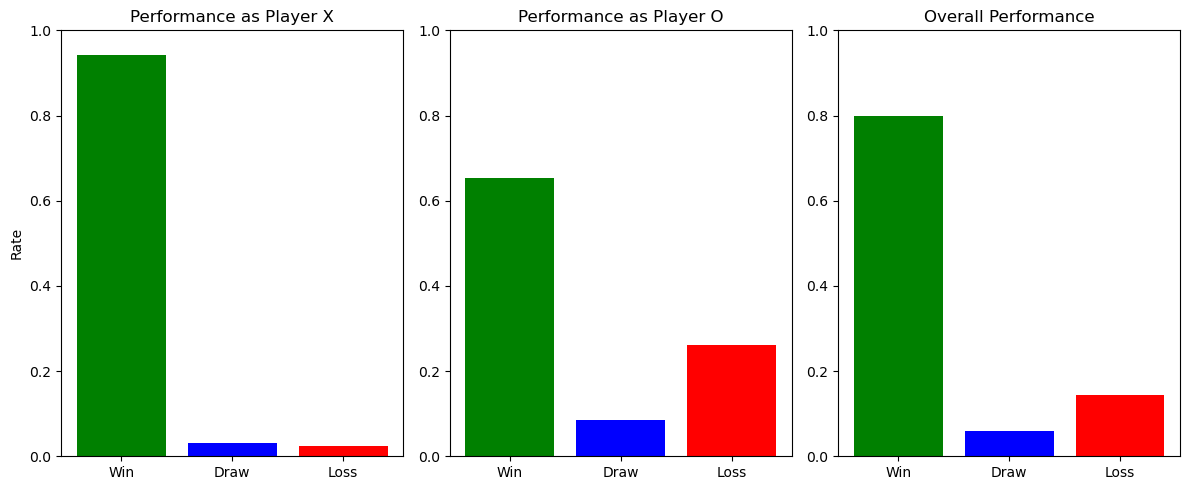

In [15]:
# Count results for X and O
counter_x = Counter(history_x)
counter_o = Counter(history_o)

# Compute rates
total_x = len(history_x)
total_o = len(history_o)
win_rate_x = counter_x[1] / total_x
draw_rate_x = counter_x[0] / total_x
loss_rate_x = counter_x[-1] / total_x

win_rate_o = counter_o[1] / total_o
draw_rate_o = counter_o[0] / total_o
loss_rate_o = counter_o[-1] / total_o

# Overall performance
total_overall = total_x + total_o
overall_counter = Counter(history_x + history_o)
win_rate_overall = overall_counter[1] / total_overall
draw_rate_overall = overall_counter[0] / total_overall
loss_rate_overall = overall_counter[-1] / total_overall

# Plotting
labels = ['Win', 'Draw', 'Loss']
x_rates = [win_rate_x, draw_rate_x, loss_rate_x]
o_rates = [win_rate_o, draw_rate_o, loss_rate_o]
overall_rates = [win_rate_overall, draw_rate_overall, loss_rate_overall]

x = range(len(labels))

plt.figure(figsize=(12, 5))

# Player X Performance
plt.subplot(1, 3, 1)
plt.bar(x, x_rates, color=['green', 'blue', 'red'])
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Performance as Player X")
plt.ylabel("Rate")

# Player O Performance
plt.subplot(1, 3, 2)
plt.bar(x, o_rates, color=['green', 'blue', 'red'])
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Performance as Player O")

# Overall Performance
plt.subplot(1, 3, 3)
plt.bar(x, overall_rates, color=['green', 'blue', 'red'])
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Overall Performance")

plt.tight_layout()
plt.show()
